In [14]:
from min_sbr import MinSBR
import os
import pandas as pd
import plotly.express as px
import platform
import time
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize 
from matplotlib import cm
%matplotlib inline
import seaborn as sns


sns.set_palette('Dark2')

In [7]:
name = '/scratch/westgroup/methanol/perturb_5000/run_0002/cantera/chem_annotated.cti'
stat = os.stat(name)
time.ctime(stat.st_mtime)

'Wed Oct 27 15:23:08 2021'

## run through a sampling of completed runs

In [8]:
# yaml_file = "/scratch/westgroup/methanol/baseline_debug/run_0009/cantera/chem_annotated.cti"
# yaml_file = "/scratch/westgroup/methanol/baseline_debug/base_run/cantera/chem_annotated.cti"
# yaml_file = "/scratch/westgroup/methanol/perturb_5000/run_0100/cantera/chem_annotated.cti"
# yaml_file = "/scratch/westgroup/methanol/meOH-synthesis/base/cantera/chem_annotated.cti"
yaml_file = "/work/westgroup/ChrisB/_01_MeOH_repos/meOH-synthesis/base/cantera/chem_annotated.cti"
count = 0
methanol = []
# for name in glob.glob('/scratch/westgroup/methanol/perturb_5000/run_00**/cantera/chem_annotated.cti'):
#     stat = os.stat(name)
#     if "Oct 27 14:5" in time.ctime(stat.st_mtime): 
rmg_model_path = os.path.dirname(name)
yaml_file = name
sbr_test = MinSBR(
    yaml_file,
    rmg_model_path,
    temperature=528,
    pressure=75,
    volume_flow=4.3e-6,  # [m^3/s]
    x_H2=0.50,  # responsibility is on caller to get these right
    x_CO2=0.25,
    x_CO=0.25,
    x_H2O=0,
    catalyst_weight=4.24e-3,
    rtol=1.0e-11,
    atol=1.0e-22,
    sensatol=1e-6,
    sensrtol=1e-6,
    reactor_type=1,
    energy="off",
    reactime=1e5,
    )

print("cox enthalpy: {:2.4e}".format(sbr_test.surf.species("CO*(14)").thermo.h(298)))
results = sbr_test.run_reactor_ss_memory()

# Too much memory? is that why it's slow?
df = pd.DataFrame.from_dict(results, orient='index')


cox enthalpy: -1.7557e+08


In [2]:
# import glob
# count = 0
# for name in glob.glob('/scratch/westgroup/methanol/perturb_5000/run_****/cantera/chem_annotated.cti'):
#     stat = os.stat(name)
#     if "Oct 26" in time.ctime(stat.st_mtime): 
# #         print("current")
# #         print(name)
#         count+=1
# print(count)

In [14]:
# yaml_file = "/scratch/westgroup/methanol/baseline_debug/run_0009/cantera/chem_annotated.cti"
# yaml_file = "/scratch/westgroup/methanol/baseline_debug/base_run/cantera/chem_annotated.cti"
yaml_file = "/scratch/westgroup/methanol/perturb_5000/run_0002/cantera/chem_annotated.cti"
# yaml_file = "/scratch/westgroup/methanol/meOH-synthesis/base/cantera/chem_annotated.cti"
# yaml_file = "/work/westgroup/ChrisB/_01_MeOH_repos/meOH-synthesis/tol_5e-1/cantera/chem_annotated.cti"

rmg_model_path = os.path.dirname(yaml_file)
sbr_test = MinSBR(
    yaml_file,
    rmg_model_path,
    temperature=528,
    pressure=75,
    volume_flow=3.32416e-5,  # [m^3/s]
    x_H2=0.50,  # responsibility is on caller to get these right
    x_CO2=0.25,
    x_CO=0.25,
    x_H2O=0,
    catalyst_weight=4.24e-3,
    rtol=1.0e-11,
    atol=1.0e-22,
    sensatol=1e-6,
    sensrtol=1e-6,
    reactor_type=1,
    energy="off",
    reactime=1e5,
    )

results = sbr_test.run_reactor_ss_memory()
print("cox enthalpy: {:2.4e}".format(sbr_test.surf.species("CO*(14)").thermo.h(298)))
# Too much memory? is that why it's slow?
df = pd.DataFrame.from_dict(results, orient='index')

# csv_path = "test_sbr_results"
# df.to_csv(csv_path)
df[:40]
# "{:2.5e}".format(sbr_test.surf.species("CO*(14)").thermo.h(298))

cox enthalpy: -1.7557e+08


,0
time (s),5149
T (K),528
P (Pa),7.59937e+06
V (m^3/s),3.32416e-05
x_CO initial,0.25
x_CO2 initial,0.25
x_H2 initial,0.5
x_H2O initial,0
CO2/(CO2+CO),0.5
(CO+CO2/H2),1


make sobol sequence and get perturbations for each run. record in a data structure

In [3]:
from torch.quasirandom import SobolEngine
# Define the uncertainty ranges based on the paper
DELTA_ALPHA_MAX = 0.15
# DELTA_E0_MAX = 30  # 3 eV is about 30 kJ/mol
DELTA_E0_MAX_J_MOL = 30000  # 3 eV is about 30000 J/mol

# only perturb vdw by +/- 0.2 eV
DELTA_E0_MAX_J_MOL_VDW = 20000

# Define the number of perturbations to run
N = 5000

# Create the pseudo randoms
sobol = SobolEngine(dimension=80, scramble=True, seed=100)
x_sobol = sobol.draw(N)



In [4]:
# Make list of lists for sobol perturbations
delta_pt_c = []
delta_pt_o = []
delta_pt_h = []
delta_pt_vdw = []

for row in x_sobol:
    delta_pt_c.append(float(DELTA_E0_MAX_J_MOL - 2.0 * row[0] * DELTA_E0_MAX_J_MOL)/9.6e4)
    delta_pt_o.append(float(DELTA_E0_MAX_J_MOL - 2.0 * row[1] * DELTA_E0_MAX_J_MOL)/9.6e4)
    delta_pt_h.append(float(DELTA_E0_MAX_J_MOL - 2.0 * row[2] * DELTA_E0_MAX_J_MOL)/9.6e4)
    delta_pt_vdw.append(float(DELTA_E0_MAX_J_MOL_VDW  - 2.0 * row[3] * DELTA_E0_MAX_J_MOL_VDW)/9.6e4)

index=0   
print(delta_pt_c[index],delta_pt_o[index],delta_pt_h[index],delta_pt_vdw[index])

-0.15345853678385415 0.11729984537760417 0.09526737467447917 -0.19670072428385416


In [101]:
df = pd.read_csv(csv_file)
df

,Unnamed: 0,time (s),T (K),P (Pa),V (m^3/s),x_CO initial,x_CO2 initial,x_H2 initial,x_H2O initial,CO2/(CO2+CO),...,CO2*(15),HCO*(16),HCOO*(17),COOH*(18),HCOOH*(19),CH2O*(20),CH3O*(21),CH3O2*(22),CH3OH*(23),H2X(25)
0,0,45146.669086,400.000000,3039750.0,0.000033,0.25,0.25,0.5,0.0,0.5,...,7.294356e-11,0.000089,3.829868e-23,2.830443e-14,1.988278e-21,3.067449e-09,9.809785e-21,4.946591e-29,3.838958e-18,0.000007
1,1,141178.714871,415.789474,3039750.0,0.000033,0.25,0.25,0.5,0.0,0.5,...,2.333053e-10,0.001070,2.028425e-21,8.251903e-13,2.459260e-18,6.330939e-08,2.983286e-18,4.727614e-26,6.212308e-15,0.000020
2,2,11442.690231,431.578947,3039750.0,0.000033,0.25,0.25,0.5,0.0,0.5,...,6.825844e-10,0.005206,3.919491e-20,9.160528e-12,4.112234e-16,4.703893e-07,1.300460e-16,6.154027e-24,1.275206e-12,0.000053
3,3,4907.134617,447.368421,3039750.0,0.000033,0.25,0.25,0.5,0.0,0.5,...,1.852709e-09,0.007469,2.029526e-19,2.831524e-11,5.124197e-15,9.843817e-07,4.645353e-16,6.275608e-23,1.906458e-11,0.000129
4,4,2450.454610,463.157895,3039750.0,0.000033,0.25,0.25,0.5,0.0,0.5,...,4.698028e-09,0.008686,7.807759e-19,6.730151e-11,3.560752e-14,1.610167e-06,1.039042e-15,3.907196e-22,1.599712e-10,0.000298
5,5,4564.690143,478.947368,3039750.0,0.000033,0.25,0.25,0.5,0.0,0.5,...,1.119820e-08,0.009464,2.601555e-18,1.429122e-10,1.802538e-13,2.400911e-06,1.965092e-15,2.005512e-21,1.032418e-09,0.000651
6,6,4355.877281,494.736842,3039750.0,0.000033,0.25,0.25,0.5,0.0,0.5,...,2.523060e-08,0.010042,7.864670e-18,2.831628e-10,6.895063e-13,3.408665e-06,3.417007e-15,8.846341e-21,5.630297e-09,0.001349
7,7,4177.410069,510.526316,3039750.0,0.000033,0.25,0.25,0.5,0.0,0.5,...,5.399699e-08,0.010522,2.201262e-17,5.328477e-10,1.997329e-12,4.684391e-06,5.636715e-15,3.269230e-20,2.698089e-08,0.002669
8,8,2991.225600,526.315789,3039750.0,0.000033,0.25,0.25,0.5,0.0,0.5,...,1.102111e-07,0.010940,5.765903e-17,9.603734e-10,4.553398e-12,6.275338e-06,8.938714e-15,1.010542e-19,1.157911e-07,0.005059
9,9,5889.631914,542.105263,3039750.0,0.000033,0.25,0.25,0.5,0.0,0.5,...,2.151939e-07,0.011302,1.422273e-16,1.664901e-09,8.757663e-12,8.219443e-06,1.370541e-14,2.708952e-19,4.489328e-07,0.009211


In [156]:
# rmg_runs_dir = "/home/moon/methanol/perturb_5000/"
rmg_runs_dir = "/scratch/westgroup/methanol/perturb_5000_correllated/"

csv_files = glob.glob(os.path.join(rmg_runs_dir, 'run_0***', 'cantera', 'ct_analysis.csv'))

P = 3039750.0000000005
V = 3.32416e-05
T = []
x_methanol = []
perturb_c = []
perturb_o = []
perturb_h = []
perturb_vdw = []

all_fields = [
#               'T (K) final',
              'N2', 'Ne',
              'H2(2)', 'CO(3)', 'CO2(4)', 'H2O(5)', 'CH2O(6)', 'HCOOH(7)', 'CH3OH(8)',
              'HCOOCH3(9)', 'CH4(24)', 'X(1)', 'H*(10)', 'O*(11)', 'OH*(12)',
              'H2O*(13)', 'CO*(14)', 'CO2*(15)', 'HCO*(16)', 'HCOO*(17)', 'COOH*(18)',
              'HCOOH*(19)', 'CH2O*(20)', 'CH3O*(21)', 'CH3O2*(22)', 'CH3OH*(23)',
              'H2X(25)', 'COX2(26)', 'SX(56)(27)', 'CHOX2(28)', 'CH3OX(29)',
              'CH2OX2(30)', 'SX(31)', 'SX(32)', 'SX(33)', 'C2HO2X(34)', 'CH4X(35)',
              'CH3X(36)', 'SX(37)', 'SX(62)(38)', 'SX(58)(39)', 'CHO2X2(40)',
              'C2H4OX(41)', 'SX(42)', 'C2H5OX(43)', 'SX(44)', 'C2H5OX(45)',
              #'SX(116)'
]

Imax = 1000
# for field in all_fields:

#field_to_plot = "HCOO*(17)"
field = "CH3OH(8)"
#field_to_plot_fname = re.sub(r'[^a-zA-Z0-9]', '', field_to_plot)
# field_to_plot_fname = re.sub(r'[^a-zA-Z0-9]', '', field)
# Plot SS MeOH concentration vs temperature

first_run = True
for i, csv_file in enumerate(csv_files):
    
    df = pd.read_csv(csv_file)
    # get run id from filename for referencing in sobol sequence
    match = re.compile('run_....')
    field_to_plot_fname = match.search(csv_file)
    run_id = int(field_to_plot_fname.group().replace("run_",""))
    
    if run_id <900:
        value = 500
        index = abs(df['T (K)'] - value).idxmin()

        
        T.append(df['T (K)'][index])
        x_methanol.append(df[field][index])
        
        
        perturb_c.append([delta_pt_c[run_id]])
        perturb_o.append([delta_pt_o[run_id]])
        perturb_h.append([delta_pt_h[run_id]])
        perturb_vdw.append([delta_pt_vdw[run_id]])


    #     if first_run:
    #         first_run = False
    #         T = df["T (K)"].values
    #         x_methanol = df[field].values
    #         points = len(df["T (K)"].values)
    #         perturb += points*[delta_pt_c[run_id]]
    #     else: 
    #         T = np.append(T,df["T (K)"].values)
    #         x_methanol = np.append(x_methanol,df[field].values)
    #         points = len(df["T (K)"].values)
    #         perturb += points*[delta_pt_c[run_id]]
        
    # select the part of the dataframe we are interested in
    if i > Imax:
        break
    if len(T) != len(perturb_c):
        print("failed, vectors are uneven")
        break
   

In [165]:
# get meoh TOF
Pres = 3039750.0 # Pa
Temp = value # K
Vflow = 3.32416e-5 # m^3/s
R = 8.3145
sites = 1.307404e-3
F = ((Pres*Vflow)/(R*Temp*sites))
x_methanol_TOF = [s*F for s in x_methanol]


In [158]:
# make nice lists
# x_methanol = [s[0] for s in x_methanol]
perturb_c = [s[0] for s in perturb_c]
perturb_o = [s[0] for s in perturb_o]
perturb_h = [s[0] for s in perturb_h]
perturb_vdw = [s[0] for s in perturb_vdw]

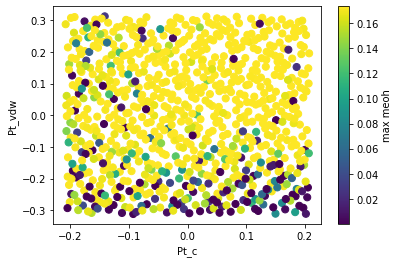

In [159]:
fig, ax = plt.subplots()
cax=ax.scatter(perturb_vdw,perturb_c,c=x_methanol_TOF, s=50)
plt.xlabel('Pt_c')
plt.ylabel('Pt_vdw')
norm = Normalize(vmin = np.min(x_methanol), vmax = np.max(x_methanol))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
cbar.ax.set_ylabel('max meoh')
plt.show()

# make contour map with inperpolation

source: 
https://stackoverflow.com/questions/66407995/improve-contour-plot-from-xyz-coordinates-in-matplotlib

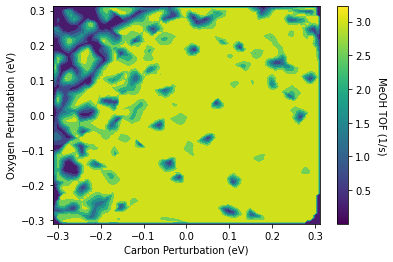

In [164]:
from scipy.interpolate import griddata

x = perturb_c
y = perturb_o
z = x_methanol_TOF

# ny, nx = 100, 200

xmin = min(x)
xmax = max(x)

ymin = min(y)
ymax = max(y)

# x = np.r_[x,xmin,xmax]
# y = np.r_[y,ymax,ymin]
# z = np.r_[z,z[0],z[-1]]
# xi = np.linspace(xmin, xmax, nx)
# yi = np.linspace(ymin, ymax, ny)

# xy = np.vstack((x, y)).T


def plot_contour(x,y,z,resolution = 100,contour_method='linear'):
    resolution = str(resolution)+'j'
    X,Y = np.mgrid[min(x):max(x):complex(resolution),   min(y):max(y):complex(resolution)]
    points = [[a,b] for a,b in zip(x,y)]
    Z = griddata(points, z, (X, Y), method=contour_method,fill_value=0.0)
    return X,Y,Z

X,Y,Z = plot_contour(x,y,z,resolution = 100,contour_method='linear')

fig, ax = plt.subplots()
ax.contourf(X,Y,Z)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

norm = Normalize(vmin = np.min(z), vmax = np.max(z))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
cbar.ax.set_ylabel('MeOH TOF (1/s)',rotation=270,labelpad=15)

ax.set_xlabel("Carbon Perturbation (eV)")
ax.set_ylabel("Oxygen Perturbation (eV)")

plt.show()

## make H2O plot

In [ ]:
# rmg_runs_dir = "/home/moon/methanol/perturb_5000/"
rmg_runs_dir = "/scratch/westgroup/methanol/perturb_5000_correllated/"

csv_files = glob.glob(os.path.join(rmg_runs_dir, 'run_0***', 'cantera', 'ct_analysis.csv'))

P = 3039750.0000000005
V = 3.32416e-05
T = []
x_methanol = []
perturb_c = []
perturb_o = []
perturb_h = []
perturb_vdw = []

all_fields = [
#               'T (K) final',
              'N2', 'Ne',
              'H2(2)', 'CO(3)', 'CO2(4)', 'H2O(5)', 'CH2O(6)', 'HCOOH(7)', 'CH3OH(8)',
              'HCOOCH3(9)', 'CH4(24)', 'X(1)', 'H*(10)', 'O*(11)', 'OH*(12)',
              'H2O*(13)', 'CO*(14)', 'CO2*(15)', 'HCO*(16)', 'HCOO*(17)', 'COOH*(18)',
              'HCOOH*(19)', 'CH2O*(20)', 'CH3O*(21)', 'CH3O2*(22)', 'CH3OH*(23)',
              'H2X(25)', 'COX2(26)', 'SX(56)(27)', 'CHOX2(28)', 'CH3OX(29)',
              'CH2OX2(30)', 'SX(31)', 'SX(32)', 'SX(33)', 'C2HO2X(34)', 'CH4X(35)',
              'CH3X(36)', 'SX(37)', 'SX(62)(38)', 'SX(58)(39)', 'CHO2X2(40)',
              'C2H4OX(41)', 'SX(42)', 'C2H5OX(43)', 'SX(44)', 'C2H5OX(45)',
              #'SX(116)'
]

Imax = 1000
# for field in all_fields:

#field_to_plot = "HCOO*(17)"
field = "H2O(5)"
#field_to_plot_fname = re.sub(r'[^a-zA-Z0-9]', '', field_to_plot)
# field_to_plot_fname = re.sub(r'[^a-zA-Z0-9]', '', field)
# Plot SS MeOH concentration vs temperature

first_run = True
for i, csv_file in enumerate(csv_files):
    
    df = pd.read_csv(csv_file)
    # get run id from filename for referencing in sobol sequence
    match = re.compile('run_....')
    field_to_plot_fname = match.search(csv_file)
    run_id = int(field_to_plot_fname.group().replace("run_",""))
    
    if run_id <800:
        value = 526
        index = abs(df['T (K)'] - value).idxmin()

        
        T.append(df['T (K)'][index])
        x_methanol.append(df[field][index])
        perturb_c.append([delta_pt_c[run_id]])
        perturb_o.append([delta_pt_o[run_id]])
        perturb_h.append([delta_pt_h[run_id]])
        perturb_vdw.append([delta_pt_vdw[run_id]])


    #     if first_run:
    #         first_run = False
    #         T = df["T (K)"].values
    #         x_methanol = df[field].values
    #         points = len(df["T (K)"].values)
    #         perturb += points*[delta_pt_c[run_id]]
    #     else: 
    #         T = np.append(T,df["T (K)"].values)
    #         x_methanol = np.append(x_methanol,df[field].values)
    #         points = len(df["T (K)"].values)
    #         perturb += points*[delta_pt_c[run_id]]
        
    # select the part of the dataframe we are interested in
    if i > Imax:
        break
    if len(T) != len(perturb_c):
        print("failed, vectors are uneven")
        break

In [211]:
import matplotlib.pyplot as plt
import pandas as pd
import re
from matplotlib.colors import Normalize 
from matplotlib import cm
%matplotlib inline

csv_files = glob.glob(os.path.join(rmg_runs_dir, 'run_0***', 'cantera', 'ct_analysis.csv'))

# T = 'all'
P = 3039750.0000000005
V = 3.32416e-05
perturb_c = []
perturb_o = []
perturb_h = []
perturb_vdw = []

all_fields = [
#               'T (K) final',
              'N2', 'Ne',
              'H2(2)', 'CO(3)', 'CO2(4)', 'H2O(5)', 'CH2O(6)', 'HCOOH(7)', 'CH3OH(8)',
              'HCOOCH3(9)', 'CH4(24)', 'X(1)', 'H*(10)', 'O*(11)', 'OH*(12)',
              'H2O*(13)', 'CO*(14)', 'CO2*(15)', 'HCO*(16)', 'HCOO*(17)', 'COOH*(18)',
              'HCOOH*(19)', 'CH2O*(20)', 'CH3O*(21)', 'CH3O2*(22)', 'CH3OH*(23)',
              'H2X(25)', 'COX2(26)', 'SX(56)(27)', 'CHOX2(28)', 'CH3OX(29)',
              'CH2OX2(30)', 'SX(31)', 'SX(32)', 'SX(33)', 'C2HO2X(34)', 'CH4X(35)',
              'CH3X(36)', 'SX(37)', 'SX(62)(38)', 'SX(58)(39)', 'CHO2X2(40)',
              'C2H4OX(41)', 'SX(42)', 'C2H5OX(43)', 'SX(44)', 'C2H5OX(45)',
              #'SX(116)'
]

Imax = 1000
# for field in all_fields:

#field_to_plot = "HCOO*(17)"
field = "CH3OH(8)"
#field_to_plot_fname = re.sub(r'[^a-zA-Z0-9]', '', field_to_plot)
# field_to_plot_fname = re.sub(r'[^a-zA-Z0-9]', '', field)
# Plot SS MeOH concentration vs temperature

first_run = True
for i, csv_file in enumerate(csv_files):
    
    # get run id from filename for referencing in sobol sequence
    match = re.compile('run_....')
    field_to_plot_fname = match.search(csv_file)
    run_id = int(field_to_plot_fname.group().replace("run_",""))
    df = pd.read_csv(csv_file)
    if run_id < 500: 
        if first_run:
            first_run = False
            T = df["T (K)"].values
            x_methanol = df[field].values
            points = len(df["T (K)"].values)
            perturb_c += points*[delta_pt_c[run_id]]
            perturb_o += points*[delta_pt_o[run_id]]
            perturb_h += points*[delta_pt_h[run_id]]
            perturb_vdw += points*[delta_pt_vdw[run_id]]
        else: 
            T = np.append(T,df["T (K)"].values)
            x_methanol = np.append(x_methanol,df[field].values)
            points = len(df["T (K)"].values)
            perturb_c += points*[delta_pt_c[run_id]]
            perturb_o += points*[delta_pt_o[run_id]]
            perturb_h += points*[delta_pt_h[run_id]]
            perturb_vdw += points*[delta_pt_vdw[run_id]]
        
    # select the part of the dataframe we are interested in
    if i > Imax:
        break
    if len(T) != len(perturb_c):
        print("failed, vectors are uneven")
        break
        

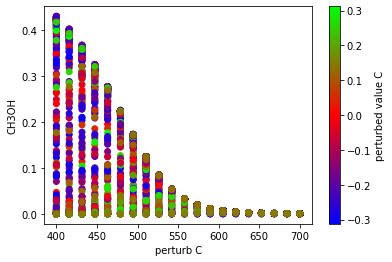

In [214]:
fig, ax = plt.subplots()
cax=ax.scatter(T, x_methanol, c=perturb_vdw,)
plt.xlabel('perturb C')
plt.ylabel("CH3OH")

norm = Normalize(vmin = np.min(perturb_c), vmax = np.max(perturb_c))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
cbar.ax.set_ylabel('perturbed value C')

plt.savefig(f'test_image.png')

In [44]:
x_methanol.max()



0.0030314851636973443

50


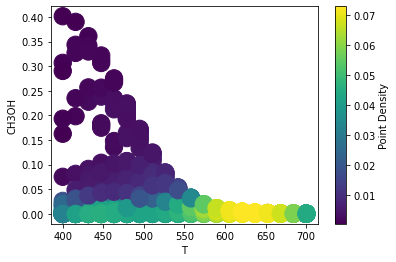

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os
import glob
import re
from matplotlib.colors import Normalize 
from matplotlib import cm
%matplotlib inline

first_run = True

# rmg_runs_dir = "/home/moon/methanol/perturb_5000/"
rmg_runs_dir = "/scratch/westgroup/methanol/perturb_5000_correllated/"

csv_files = glob.glob(os.path.join(rmg_runs_dir, 'run_00**', 'cantera', 'ct_analysis.csv'))

print(len(csv_files))

T = 'all'
P = 3039750.0000000005
V = 3.32416e-05

all_fields = [
#               'T (K) final',
              'N2', 'Ne',
              'H2(2)', 'CO(3)', 'CO2(4)', 'H2O(5)', 'CH2O(6)', 'HCOOH(7)', 'CH3OH(8)',
              'HCOOCH3(9)', 'CH4(24)', 'X(1)', 'H*(10)', 'O*(11)', 'OH*(12)',
              'H2O*(13)', 'CO*(14)', 'CO2*(15)', 'HCO*(16)', 'HCOO*(17)', 'COOH*(18)',
              'HCOOH*(19)', 'CH2O*(20)', 'CH3O*(21)', 'CH3O2*(22)', 'CH3OH*(23)',
              'H2X(25)', 'COX2(26)', 'SX(56)(27)', 'CHOX2(28)', 'CH3OX(29)',
              'CH2OX2(30)', 'SX(31)', 'SX(32)', 'SX(33)', 'C2HO2X(34)', 'CH4X(35)',
              'CH3X(36)', 'SX(37)', 'SX(62)(38)', 'SX(58)(39)', 'CHO2X2(40)',
              'C2H4OX(41)', 'SX(42)', 'C2H5OX(43)', 'SX(44)', 'C2H5OX(45)',
              #'SX(116)'
]

Imax = 1000
# for field in all_fields:

#field_to_plot = "HCOO*(17)"
field = "CH3OH(8)"
#field_to_plot_fname = re.sub(r'[^a-zA-Z0-9]', '', field_to_plot)
# field_to_plot_fname = re.sub(r'[^a-zA-Z0-9]', '', field)
# Plot SS MeOH concentration vs temperature

first_run = True
for i, csv_file in enumerate(csv_files):
    df = pd.read_csv(csv_file)
    if first_run:
        first_run = False
        T = df["T (K)"].values
        x_methanol = df[field].values
    else: 
        T = np.append(T,df["T (K)"].values)
        x_methanol = np.append(x_methanol,df[field].values)
        
    # select the part of the dataframe we are interested in
    if i>Imax:
        break

# Calculate the point density
xy = np.vstack([T,x_methanol])
z = gaussian_kde(xy)(xy)        
fig, ax = plt.subplots()
cax=ax.scatter(T, x_methanol, c=z, s=300)
plt.xlabel('T')
plt.ylabel("CH3OH")


norm = Normalize(vmin = np.min(z), vmax = np.max(z))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
cbar.ax.set_ylabel('Point Density')

plt.savefig(f'test_image.png')

# plt.show()
# plt.xlabel('T')
# plt.ylabel(field)
# plt.savefig(f'test_image.png')
# plt.clf()


In [ ]:
P = 3039750.0000000005
V = 3.32416e-05

df = pd.read_csv(csv_files[1])
df
# data_slice = df[df["P (Pa)"] == P]
# data_slice = data_slice[data_slice["V (m^3/s)"] == V]

# T = data_slice["T (K)"].values
# T

In [ ]:
# Load the iris dataset provided by the library
import plotly.express as px
# Create the chart:
value = "T (K)"
giant_df[value] = giant_df[value].astype(float)
min_val = giant_df[value].min()
max_val = giant_df[value].max()
fig = px.parallel_coordinates(
    giant_df, 
    color=value, 
    dimensions=["T (K)",'CO(3)', 'CO2(4)', 'H2O(5)',"CH3OH(8)","H2X(25)",],
#     color_continuous_scale=px.colors.diverging.Tealrose,
    color_continuous_scale = px.colors.diverging.Tealrose,
    range_color=[giant_df["T (K)"].min(),700],
    color_continuous_midpoint=5)

# Hide the color scale that is useless in this case
fig.update_layout(coloraxis_showscale=True)

# Show the plot
fig.show()

In [ ]:
giant_df[:10]

In [ ]:
# Load the iris dataset provided by the library
import plotly.express as px
# Load the iris dataset provided by the library
df = px.data.iris()

# Create the chart:
fig = px.parallel_coordinates(
    df, 
    color="species_id", 
    labels={"species_id": "Species","sepal_width": "Sepal Width", "sepal_length": "Sepal Length",},
    color_continuous_scale=px.colors.diverging.Tealrose,
    color_continuous_midpoint=2)

# Hide the color scale that is useless in this case
fig.update_layout(coloraxis_showscale=False)

# Show the plot
fig.show()

In [ ]:
csv_files = glob.glob(os.path.join(rmg_runs_dir, 'run_00**', 'cantera', 'ct_analysis_graaf.csv'))

In [ ]:
csv_files

In [ ]:
csv_list = []
mse_meoh = []
mse_h2o = []

for i, csv_file in enumerate(csv_files):
    df = pd.read_csv(csv_file)
    try:
        mse_meth = df["error squared MeOH TOF"].sum()/len(df["error squared MeOH TOF"])
        mse_wat = df["error squared H2O TOF"].sum()/len(df["error squared H2O TOF"])
        csv_list.append(csv_file)
        mse_meoh.append(mse_meth)
        mse_h2o.append(mse_wat)
    except:
        print(f'no column in {csv_file}')

    
print(min(mse_meoh),min(mse_h2o))
print(mse_meoh.index(min(mse_meoh)),mse_h2o.index(min(mse_h2o)))

meoh_csv = csv_list[mse_meoh.index(min(mse_meoh))]
h2o_csv = csv_list[mse_h2o.index(min(mse_h2o))]


In [ ]:
# load in Graaf experimental data
# exclude feed 8 because it is a monolith reactor
path_str = "../Graaf_data/combined_experimental_runs.xlsx"
df_graaf = pd.read_excel(path_str , engine='openpyxl')  

In [ ]:
df_graaf

In [ ]:
rmg_data = "2021_09_22_0110_268b46_ran_with_sandia_reaction_added_in_Surface_Methane__Graaf_ss_runs_all.csv"
df_rmg = pd.read_csv(meoh_csv)
df_rmg

In [ ]:
import math
count = 0
found = False
for indexrmg, row_rmg in df_rmg.iterrows():
    for index_graaf, row_graaf in df_graaf.iterrows():
        if (math.isclose(row_graaf["10^6 * V (M^3/s)"], row_rmg["V (m^3/s)"]*1e6,rel_tol=1e-2) and
            math.isclose(row_graaf["T(K)"], row_rmg["T (K)"],rel_tol=1e-2) and
            math.isclose(row_graaf["p (bar)"], row_rmg["P (Pa)"]/1e5,rel_tol=1e-2) and
            math.isclose(row_graaf["feed Yco"], row_rmg["x_CO initial"],rel_tol=1e-2) and
            math.isclose(row_graaf["feed Yco2"], row_rmg["x_CO2 initial"],rel_tol=1e-2) and
            math.isclose(row_graaf["feed Yh2"], row_rmg["x_H2 initial"],rel_tol=1e-2)):
            
            new_series_data = row_graaf.append(row_rmg)
            found = True
    if found:
        if count == 0:
            df_combined_rmg = pd.DataFrame(new_series_data, index = new_series_data.index).transpose()
            count+=1
            
        if count > 0:
            df_combined_rmg = df_combined_rmg.append(pd.DataFrame(new_series_data).transpose())
            count+=1
            
        found = False
        
            
print(count)

In [ ]:
df_rmg.columns

In [ ]:
ax = df_combined_rmg.plot.scatter("graaf MeOH TOF 1/s","RMG MeOH TOF 1/s",loglog=True,color="b")
# df_combined_rmg.plot.scatter("H2O TOF (mol/site/s)","RMG H2O TOF (1/s)",loglog=True,color="r", ax=ax)

ax.set_ylim(1e-4, 1e-1)
ax.set_xlim(1e-4, 1e-1)

ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(labels=["RMG model"])


# make x=y line
plt.gca().set_xlim(left=1e-4)
plt.gca().set_ylim(bottom=1e-4)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

In [ ]:
rmg_data = "2021_09_22_0110_268b46_ran_with_sandia_reaction_added_in_Surface_Methane__Graaf_ss_runs_all.csv"
df_rmg = pd.read_csv(h2o_csv)
df_rmg

import math
count = 0
found = False
for indexrmg, row_rmg in df_rmg.iterrows():
    for index_graaf, row_graaf in df_graaf.iterrows():
        if (math.isclose(row_graaf["10^6 * V (M^3/s)"], row_rmg["V (m^3/s)"]*1e6,rel_tol=1e-2) and
            math.isclose(row_graaf["T(K)"], row_rmg["T (K)"],rel_tol=1e-2) and
            math.isclose(row_graaf["p (bar)"], row_rmg["P (Pa)"]/1e5,rel_tol=1e-2) and
            math.isclose(row_graaf["feed Yco"], row_rmg["x_CO initial"],rel_tol=1e-2) and
            math.isclose(row_graaf["feed Yco2"], row_rmg["x_CO2 initial"],rel_tol=1e-2) and
            math.isclose(row_graaf["feed Yh2"], row_rmg["x_H2 initial"],rel_tol=1e-2)):
            
            new_series_data = row_graaf.append(row_rmg)
            found = True
    if found:
        if count == 0:
            df_combined_rmg = pd.DataFrame(new_series_data, index = new_series_data.index).transpose()
            count+=1
            
        if count > 0:
            df_combined_rmg = df_combined_rmg.append(pd.DataFrame(new_series_data).transpose())
            count+=1
            
        found = False
        
            
print(count)

In [ ]:
ax = df_combined_rmg.plot.scatter("graaf H2O TOF 1/s","RMG H2O TOF 1/s",loglog=True,color="b")
# df_combined_rmg.plot.scatter("H2O TOF (mol/site/s)","RMG H2O TOF (1/s)",loglog=True,color="r", ax=ax)
ax.set_ylim(1e-4, 1e-1)
ax.set_xlim(1e-4, 1e-1)

ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(labels=["RMG model"])


# make x=y line
plt.gca().set_xlim(left=1e-4)
plt.gca().set_ylim(bottom=1e-4)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

In [ ]:
df_graaf["feed Yh2"].min()